# Determine Mode Share From South African National Household Travel Data

As the title suggests the functions defined in this notebook are used to process the South African National Household Travel Survey 
It allows the 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file = 'nhts-2013-person-v1-20140718.csv'
PGFile = 'mode-share-link.csv'
 
df = pd.read_csv(file)
dfPG = pd.read_csv(PGFile)

In [3]:
def plot(col):    
    '''
    Plot the responses of a certain column from the NHTS data by response number and number of respondents 
    Reformats the column data in order to print a logical representation
    This works assuming df is the NHTS data read from the files provided
    
    '''
    
    dfg = df.groupby([col]).UQNO.count()
    fig, ax = plt.subplots(figsize=(15,7))

    plt.bar(dfg.index, dfg)

    ax.set_xlabel('Response')
    ax.set_ylabel('Count of ' + col)
    ax.set_title(col)
    
    fig.savefig('graph_{}.png'.format(col))

In [3]:
def replace(df): 
    '''
    Replace mode from NHHTS columns with main mode 
    ie. either PuT or PrT or Walk and Employment status
    
    Each mode represents the mode which was used for the majority of the trip
    PuT: Public Transport Mode
    PrT: Main Private Transport Mode
    Walk: Walking mode
    
    '''

    df.Q33EDUII = df.Q33EDUII.replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 88, 99], 
                                        ['School', 'School', 'Student', 'None',
                                         'Student', 'Student', 'Student',
                                         'None', 'None', 'None', 'None'])

    df.Q41WORK = df.Q41WORK.replace([1, 2, 3, 8], 
                                    ['EmployedF', 'EmployedIF', 'None', 'None'])

    df.Q42YNOTWRKK = df.Q42YNOTWRKK.replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 88, 99], 
                                        ['None', 'Other', 'Retired', 'Other', 'Unemployed', 'Unemployed',
                                         'Other', 'EmployedF', 'Other', 'None', 'None'])

    df.Mainmode_q312 = df.Mainmode_q312.replace([1, 2, 3, 4, 5, 6, 7, 88, 99], 
                                        ['PuT', 'PuT', 'PuT', 'PrT', 'PrT', 'Walk',
                                         'Other', 'None', 'None'])
    
    df.Mainmode_q421 = df.Mainmode_q421.replace([1, 2, 3, 4, 5, 6, 7, 88, 99], 
                                        ['PuT', 'PuT', 'PuT', 'PrT', 'PrT', 'Walk',
                                         'Other', 'None', 'None'])
    
    df.Q63MAINM = df.Q63MAINM.replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20, 
                                           21, 22, 88, 99], 
                                        ['PuT', 'PuT', 'PuT', 'PuT', 'PuT', 'PuT',
                                         'PuT', 'PrT', 'PrT', 'PrT', 'PrT', 'PrT',
                                         'PrT', 'PrT', 'PrT', 'Cycl', 'PrT',
                                         'PrT', 'PrT', 'PuT', 'Walk', 'None',
                                         'None', 'None'])
    
    return df

In [3]:
def mode(PERSON_GROUP, Q312MODE1, Q412CYC, Mainmode_q312, Mainmode_q421, Q63MAINM):
    if Q312MODE1 == 16 or Q412CYC == 1:
        x = 'Cycl'
    elif PERSON_GROUP == "EmployedF" or PERSON_GROUP == "EmployedIF":
        x = Mainmode_q421
    elif PERSON_GROUP == "School" or PERSON_GROUP == "Student":
        x = Mainmode_q312
    else:
        x = Q63MAINM    
    
    return x

In [3]:
def calculate_ms_percentage(df, dfPG, TAZCODE = 0):
    """
    Calculate the modal split percenatage for a certain Transport Analysis Zone 
    Modes are based on the format specified in the mode-share-link.csv file
    Parameters
    ----------
    df : dataframe containing national household travel survey data
    dfPG : dataframe containing matching person and travel classes 
    TAZCODE is the transport analysis zone code which corresponds to the NHTS for which you are interested
    """
    
    if TAZCODE == 0:
        print("TAZDODE = " + TAZCODE)
    else:
        df = df[df['TAZCODE'] == TAZCODE]
            
    dfs = df.groupby(['Quintile', 'Q33EDUII', 'Q41WORK', 'Q42YNOTWRKK', 'Q312MODE1', 'Q312MODE2', 'Q312MODE3', 'Q411WLK', 
                      'Q412CYC', 'Q413DRIV', 'Q414TYPVEH', 'Mainmode_q312', 'Mainmode_q421', 'Q63MAINM']).UQNO.count().reset_index()

    dfs['Q33_41_42'] = dfs['Q33EDUII'] +  dfs['Q41WORK'] + dfs['Q42YNOTWRKK']

    dfs = dfs.merge(dfPG, left_on='Q33_41_42', right_on='Q33_41_42')

    dfs['MODE'] = dfs.apply(lambda x: mode(x['PERSON_GROUP'], x['Q312MODE1'], x['Q412CYC'], x['Mainmode_q312'], x['Mainmode_q421'], x['Q63MAINM']), axis=1)

    dfs = dfs.groupby(['Quintile', 'PERSON_GROUP', 'MODE']).UQNO.sum().reset_index()
    dfs['PERSON_GROUP'] = dfs['PERSON_GROUP'] + dfs['Quintile'].astype(str)
    dfs = dfs.groupby(['PERSON_GROUP', 'MODE']).UQNO.sum().reset_index()
    dfs = dfs.pivot(index='PERSON_GROUP', columns='MODE', values='UQNO')

    dfs = dfs.fillna(0)

    dfs['TOTAL'] = dfs['Cycl'] + dfs['PrT'] + dfs['PuT'] + dfs['Walk']

    dfs['CyclP'] = dfs['Cycl'] / dfs['TOTAL']

    dfs['PrTP'] = dfs['PrT'] / dfs['TOTAL']

    dfs['PuTP'] = dfs['PuT'] / dfs['TOTAL']

    dfs['WalkP'] = dfs['Walk'] / dfs['TOTAL']
    
    return dfs.fillna(0)

In [3]:
def plot_modeshare(modeshare, TAZCODE):
    """
    Plot results of modeshare calculation
    Parameters
    ----------
    modeshare : dataframe
    Dataframe holding the results of the modeshare function
    """
    
    category_names = ['CyclP', 'PrTP', 'PuTP', 'WalkP']

    results = modeshare[['CyclP', 'PrTP', 'PuTP', 'WalkP']] * 100
    
    labels = list(results.index)
    data = np.array(list(results.values))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 15))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'black' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center',
                        color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')
    
    fig.savefig('mode_share_{}.png'.format(TAZCODE))
    
    return fig, ax

In [3]:
def save(df, TAZCODE):
    """
    Simple function to save the modeshare CSV with the TAZCODE appended to filename
    """
    df.to_csv('mode-share-{}s.csv'.format(TAZCODE))

In [3]:
def print_columns(df):
    """
    Print the columns of the NHTS datadrame
    """
    for columns in df.columns:
        print(columns)

In [4]:
TAZCODE = 9017

replace(df)

modeshare = calculate_ms_percentage(df, dfPG, TAZCODE = TAZCODE)

try:
    save(modeshare, TAZCODE)
    print('completed')
except:
    print('Please close the mode share file and try again')
    

completed


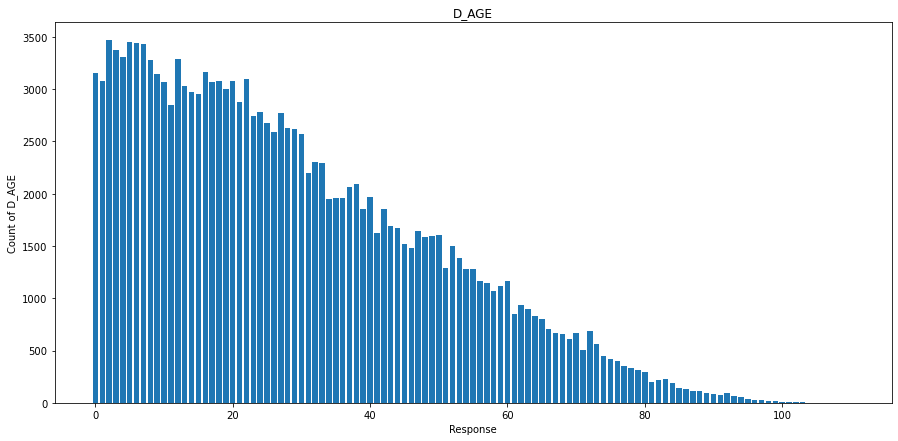

In [5]:
plot('D_AGE')

(<Figure size 662.4x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22583aab6a0>)

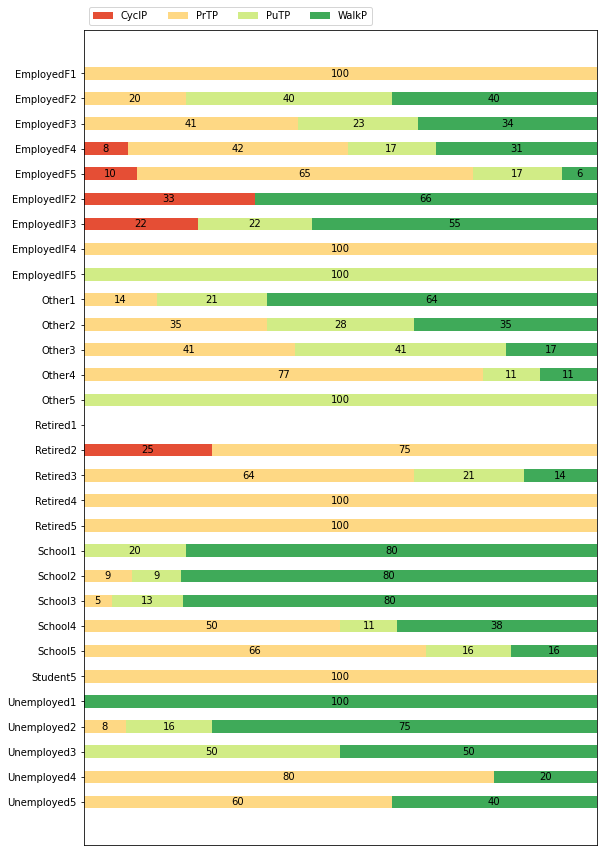

In [6]:
plot_modeshare(modeshare, TAZCODE)